## Notebook to investigate Serious Shortage Protocol data

A number of serious shortage protocols (SSP040-SSP047) were in place during the Group A strep outbreak which occured at the end of 2022/start of 2023. Under a Freedom of Information (FOI) request ([FOI 01079](https://opendata.nhsbsa.net/dataset/foi-01079)) the NHS BSA provided data on items dispensed under an SSP. This notebook analyses the data provided under the FOI and extracts the items likely to have been dispensed under the SSPs relating to Group A strep treatment.

- [Imports](#IMPORTS)
- [Load data](#LOADDATA)
- [Filter antibiotics](#FILTERDATA)
- [Create VTM dataframe](#VTMDF)
- [Transform monthly data](#TransformYM)
- [Transform totals data](#TransformTotals)
- [Sum Total Items](#SumOfItems)
- [Plot monthly data](#PlotYM)
- [Plot totals data](#PlotTotals)

<a id='IMPORTS'></a>
### Imports
Import libraries required for analysis

In [1]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

<a id='LOADDATA'></a>
### Load data from FOI supplied CSV
NHS BSA have supplied data on SSP usage in [FOI 01079](https://opendata.nhsbsa.net/dataset/foi-01079)

In [2]:
SSP_DF=pd.read_csv('FOI01079.csv', parse_dates=['YEAR_MONTH'])
SSP_DF.head()

,YEAR_MONTH,PRESENTATION_BNF,PRESENTATION_BNF_DESCR,ITEMS,TOTAL QUANTITY
0,201910,0403030E0AAALAL,Fluoxetine 10mg capsules,13,361
1,201910,0403030E0AAAPAP,Fluoxetine 10mg tablets,529,17419
2,201910,0403030E0AAAAAA,Fluoxetine 20mg capsules,835,47041
3,201910,0403030E0AAACAC,Fluoxetine 20mg/5ml oral solution,71,5880
4,201910,0403030E0AAAHAH,Fluoxetine 20mg/5ml oral solution sugar free,15,1330


<a id='FILTERDATA'></a>
### Filter antibiotics data
Filter data to only antibiotics based on pseudo-BNF code - antibiotics begin with 0501

In [3]:
SSP_abx_DF = SSP_DF.loc[SSP_DF["PRESENTATION_BNF"].str.startswith('0501', na=False)].copy()
SSP_abx_DF["VTM_BNF"] = SSP_abx_DF["PRESENTATION_BNF"].str[:9]
SSP_abx_DF

,YEAR_MONTH,PRESENTATION_BNF,PRESENTATION_BNF_DESCR,ITEMS,TOTAL QUANTITY,VTM_BNF
396,202212,0501013B0AAAJAJ,Amoxicillin 125mg/5ml oral suspension,414,89300,0501013B0
397,202212,0501013B0AAASAS,Amoxicillin 125mg/5ml oral suspension sugar free,506,115600,0501013B0
398,202212,0501013B0AAAAAA,Amoxicillin 250mg capsules,429,14076,0501013B0
399,202212,0501013B0AAAKAK,Amoxicillin 250mg/5ml oral suspension,629,123400,0501013B0
400,202212,0501013B0AAATAT,Amoxicillin 250mg/5ml oral suspension sugar free,1392,273500,0501013B0
...,...,...,...,...,...,...
573,202302,0501011P0AAADAD,Phenoxymethylpenicillin 125mg/5ml oral solution,767,238800,0501011P0
574,202302,0501011P0AAARAR,Phenoxymethylpenicillin 125mg/5ml oral solutio...,214,70200,0501011P0
575,202302,0501011P0AAAJAJ,Phenoxymethylpenicillin 250mg tablets,860,32620,0501011P0
576,202302,0501011P0AAAFAF,Phenoxymethylpenicillin 250mg/5ml oral solution,44,7600,0501011P0


<a id='VTMDF'></a>
### Create a dataframe of Virtual Therapeutic Moieties (VTMs)
Create a dataframe of VTMs of included antibiotics to allow grouping by VTM.
This links VTM BNF code to VTM text description. Various salts of erythromycin linked to same text description.

In [4]:
VTM = {
    "0501013B0": "Amoxicillin",
    "0501050A0": "Azithromycin",
    "0501021A0": "Cefaclor",
    "0501021L0": "Cefalexin",
    "0501050B0": "Clarithromycin",
    "0501013K0": "Co-amoxiclav",
    "0501050C0": "Erythromycin", # Erythromycin
    "0501050H0": "Erythromycin", # Erythromycin ethyl succinate
    "0501050N0": "Erythromycin", # Erythromycin stearate
    "0501012G0": "Flucloxacillin",
    "0501011P0": "Phenoxymethylpenicillin"
}
VTM_DF=pd.DataFrame.from_dict(VTM.items())
VTM_DF=VTM_DF.rename(columns={0: "VTM_BNF", 1: "VTM"})
VTM_DF

,VTM_BNF,VTM
0,0501013B0,Amoxicillin
1,0501050A0,Azithromycin
2,0501021A0,Cefaclor
3,0501021L0,Cefalexin
4,0501050B0,Clarithromycin
5,0501013K0,Co-amoxiclav
6,0501050C0,Erythromycin
7,0501050H0,Erythromycin
8,0501050N0,Erythromycin
9,0501012G0,Flucloxacillin


<a id='TransformYM'></a>
### Transform monthly data
Group VTMs and transform to give monthly counts of items by VTM.

In [5]:
#Join VTM to SSP data
SSP_abx_DF_incVTM = pd.merge(SSP_abx_DF, VTM_DF)

#Groupby date and VTM
SSP_abx_DF_incVTM_groupedYM=SSP_abx_DF_incVTM.groupby(by=["YEAR_MONTH", "VTM"], dropna=False, as_index=False).sum()

#Pivot to columns
SSP_abx_DF_incVTM_groupedYM = SSP_abx_DF_incVTM_groupedYM.pivot(index='YEAR_MONTH', columns='VTM', values='ITEMS')

#Replace NA with 0
SSP_abx_DF_incVTM_groupedYM=SSP_abx_DF_incVTM_groupedYM.fillna(0)

SSP_abx_DF_incVTM_groupedYM

VTM,Amoxicillin,Azithromycin,Cefaclor,Cefalexin,Clarithromycin,Co-amoxiclav,Erythromycin,Flucloxacillin,Phenoxymethylpenicillin
YEAR_MONTH,,,,,,,,,
202212,6317.0,10.0,4.0,253.0,221.0,69.0,102.0,656.0,4991.0
202301,6682.0,2.0,0.0,131.0,429.0,38.0,95.0,549.0,3976.0
202302,3749.0,0.0,0.0,52.0,68.0,39.0,35.0,189.0,1888.0


<a id='TransformTotals'></a>
### Transform total data
Group VTMs and transform to give total counts of items by VTM.

In [6]:
#Groupby date and VTM
SSP_abx_DF_incVTM_groupedVTM=SSP_abx_DF_incVTM.groupby(by=["VTM"], dropna=False, as_index=False).sum()

#Drop Total Quantity
SSP_abx_DF_incVTM_groupedVTM=SSP_abx_DF_incVTM_groupedVTM.drop(columns=['TOTAL QUANTITY'])

#Sort by items
SSP_abx_DF_incVTM_groupedVTM=SSP_abx_DF_incVTM_groupedVTM.sort_values(by=['ITEMS'], ascending=False)

#Transpose to columns
#SSP_abx_DF_incVTM_groupedVTM=SSP_abx_DF_incVTM_groupedVTM.set_index('VTM').T

#Replace NA with 0
#SSP_abx_DF_incVTM_groupedVTM=SSP_abx_DF_incVTM_groupedVTM.fillna(0)

SSP_abx_DF_incVTM_groupedVTM

,VTM,ITEMS
0,Amoxicillin,16748
8,Phenoxymethylpenicillin,10855
7,Flucloxacillin,1394
4,Clarithromycin,718
3,Cefalexin,436
6,Erythromycin,232
5,Co-amoxiclav,146
1,Azithromycin,12
2,Cefaclor,4


<a id='SumOfItems'></a>
### Sum of SSP items
Sum total items

In [7]:
SSP_abx_DF_incVTM_groupedVTM['ITEMS'].sum()

30545

<a id='PlotYM'></a>
### Plot monthly data
Plot monthly items by VTM

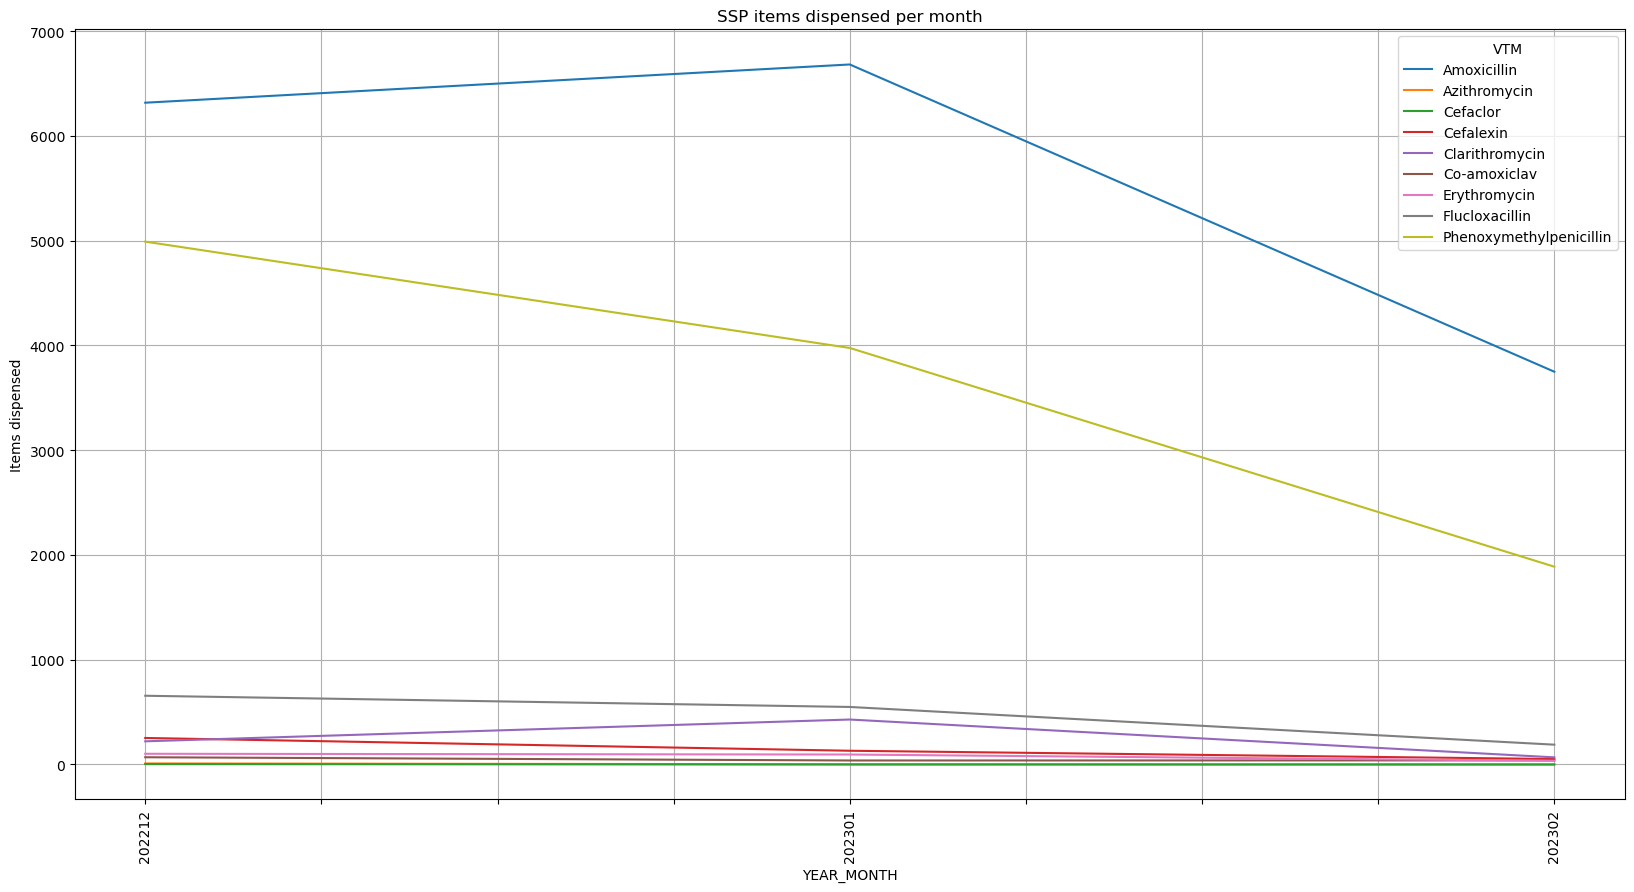

In [8]:
df=SSP_abx_DF_incVTM_groupedYM
ax = df.plot(kind='line', title='SSP items dispensed per month', figsize=(20, 10))
plt.xticks(rotation=90);
plt.ylabel('Items dispensed');
plt.grid();

<a id='PlotTotals'></a>
### Plot totals
Plot total items by VTM

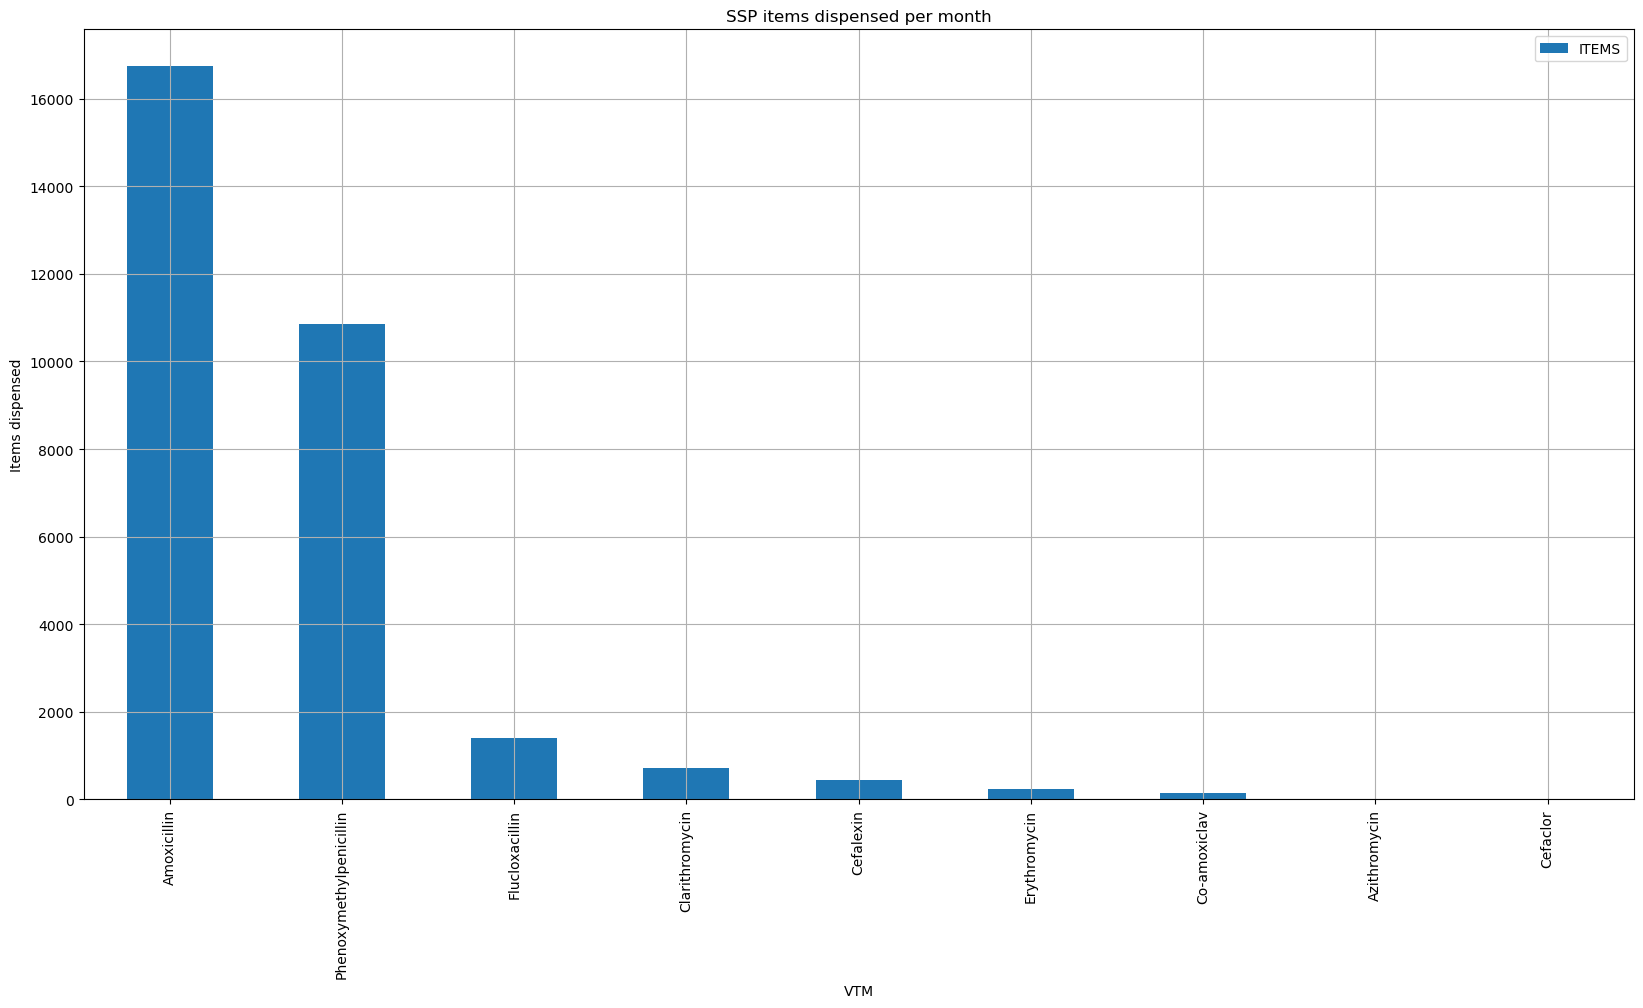

In [9]:
df=SSP_abx_DF_incVTM_groupedVTM
ax = df.plot(kind='bar', x='VTM', title='SSP items dispensed per month', figsize=(20, 10))
plt.xticks(rotation=90);
plt.ylabel('Items dispensed');
plt.grid();